# Preprocessing

In [ ]:
import os

def list_folders_and_files(root_dir):
    """
    Lists all folders and displays the first two files in each folder.

    Parameters:
    - root_dir (str): The root directory to scan.
    """
    for foldername, subfolders, filenames in os.walk(root_dir):
        # Get relative path for readability
        relative_path = os.path.relpath(foldername, root_dir)
        print(f"\n📂 Folder: {relative_path}")

        # Show first two files if available
        if filenames:
            first_two_files = filenames[:7]
            for file in first_two_files:
                print(f"    📄 {file}")
        else:
            print("    (No files in this folder)")

# Example Usage: Change 'your_directory_path' to your actual folder path
root_directory = "BCCD Dataset with mask"  # Change this to your folder path
list_folders_and_files(root_directory)


📂 Folder: .
    (No files in this folder)

📂 Folder: test
    (No files in this folder)

📂 Folder: test/mask
    📄 e02301ac-68f7-4daf-b2ba-254b917f1cca.png
    📄 e11515b4-9527-4c23-a0ba-43719bacca0d.png
    📄 e13f2327-fbf4-4d84-a8c1-09cb1e449c8c.png
    📄 e16c0dab-780d-4035-872e-1bb91e49f9d2.png
    📄 e1937e32-85d5-4cd8-bb4a-b9cf8ee7ceeb.png
    📄 e234ce8b-4ec4-4d93-9068-d7854d77ddf4.png
    📄 e26b88c6-5884-4b5c-94d7-ad780379c8ad.png

📂 Folder: test/original
    📄 e02301ac-68f7-4daf-b2ba-254b917f1cca.jpg
    📄 e11515b4-9527-4c23-a0ba-43719bacca0d.png
    📄 e13f2327-fbf4-4d84-a8c1-09cb1e449c8c.png
    📄 e16c0dab-780d-4035-872e-1bb91e49f9d2.png
    📄 e1937e32-85d5-4cd8-bb4a-b9cf8ee7ceeb.png
    📄 e234ce8b-4ec4-4d93-9068-d7854d77ddf4.png
    📄 e26b88c6-5884-4b5c-94d7-ad780379c8ad.jpg

📂 Folder: train
    (No files in this folder)

📂 Folder: train/mask
    📄 002f20ad-2ace-499c-9335-c9080bc3e6b5.png
    📄 003a89b0-a095-417a-8dd6-f408339bbc68.png
    📄 003d1cdc-0aec-430b-90e0-f4d82135b1ac.p

In [ ]:
import os
import numpy as np
from PIL import Image

# 1. Paths
BASE_DIR = "BCCD Dataset with mask"
TRAIN_IMG_DIR = os.path.join(BASE_DIR, "train/original")
TRAIN_MASK_DIR = os.path.join(BASE_DIR, "train/mask")

# 2. Supported image formats
IMG_EXTENSIONS = (".jpg", ".jpeg", ".png", ".tif", ".tiff")

# 3. Get filenames from the image folder
image_filenames = sorted([
    f for f in os.listdir(TRAIN_IMG_DIR)
    if f.lower().endswith(IMG_EXTENSIONS)
])

# 4. Create a mask dict (base name → full path)
mask_filenames = os.listdir(TRAIN_MASK_DIR)
mask_dict = {
    os.path.splitext(f)[0].lower(): os.path.join(TRAIN_MASK_DIR, f)
    for f in mask_filenames if f.lower().endswith(".png")  # Assuming masks are always .png
}

# 5. Match images to masks
valid_image_paths = []
valid_mask_paths = []

for img_name in image_filenames:
    base_name = os.path.splitext(img_name)[0].lower()

    if base_name in mask_dict:
        img_path = os.path.join(TRAIN_IMG_DIR, img_name)
        mask_path = mask_dict[base_name]
        valid_image_paths.append(img_path)
        valid_mask_paths.append(mask_path)
    else:
        print(f"⚠️ No matching mask for image: {img_name}")

print(f"\n✅ Matched {len(valid_image_paths)} image-mask pairs.")

# 6. Resizing + Augmentation
try:
    from PIL.Image import Resampling
    RESAMPLE = Resampling.LANCZOS
except ImportError:
    RESAMPLE = Image.LANCZOS

def resize_to_512(image, target_size=512):
    return image.resize((target_size, target_size), RESAMPLE)

def augment_by_rotation(image, mask):
    angles = [0, 90, 180, 270]
    return [(image.rotate(a), mask.rotate(a)) for a in angles]

# 7. Processing
all_images = []
all_masks = []

for img_path, mask_path in zip(valid_image_paths, valid_mask_paths):
    with Image.open(img_path) as img, Image.open(mask_path) as msk:
        img = resize_to_512(img.convert("RGB"))
        msk = resize_to_512(msk.convert("L"))

        for aug_img, aug_msk in augment_by_rotation(img, msk):
            aug_img_arr = np.array(aug_img)
            aug_msk_arr = np.expand_dims(np.array(aug_msk), axis=-1)

            if aug_img_arr.ndim == 2:  # Grayscale fallback
                aug_img_arr = np.stack([aug_img_arr]*3, axis=-1)

            all_images.append(aug_img_arr)
            all_masks.append(aug_msk_arr)

# 8. Convert to NumPy
all_images = np.array(all_images)
all_masks = np.array(all_masks)

print("\n✅ Final Dataset Stats:")
print(f"  🔸 Images: {all_images.shape}")
print(f"  🔸 Masks : {all_masks.shape}")



✅ Matched 1169 image-mask pairs.

✅ Final Dataset Stats:
  🔸 Images: (4676, 512, 512, 3)
  🔸 Masks : (4676, 512, 512, 1)


In [ ]:
from sklearn.model_selection import train_test_split

# ----------------------------------------------
# 6. TRAIN/TEST/VALIDATION SPLIT
# ----------------------------------------------
# Example: 70% train, 15% validation, 15% test
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# First split off test set
X_temp, X_test, Y_temp, Y_test = train_test_split(
    all_images, all_masks,
    test_size=test_ratio,
    random_state=42
)

# Then split the temp into train and val
val_size = val_ratio / (train_ratio + val_ratio)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp,
    test_size=val_size,
    random_state=42
)
print("Train set:", X_train.shape, Y_train.shape)
print("Val set:  ", X_val.shape,   Y_val.shape)
print("Test set: ", X_test.shape,  Y_test.shape)




Train set: (3272, 512, 512, 3) (3272, 512, 512, 1)
Val set:   (702, 512, 512, 3) (702, 512, 512, 1)
Test set:  (702, 512, 512, 3) (702, 512, 512, 1)


In [ ]:
# ----------------------------------------------
# 7. SAVE AS .NPY FILES
# ----------------------------------------------
np.save(os.path.join(BASE_DIR, "X_trainCellSeg.npy"), X_train)
np.save(os.path.join(BASE_DIR, "Y_trainCellSeg.npy"), Y_train)

np.save(os.path.join(BASE_DIR, "X_valCellSeg.npy"), X_val)
np.save(os.path.join(BASE_DIR, "Y_valCellSeg.npy"), Y_val)

np.save(os.path.join(BASE_DIR, "X_testCellSeg.npy"), X_test)
np.save(os.path.join(BASE_DIR, "Y_testCellSeg.npy"), Y_test)

print("Done! Arrays saved as .npy files in:", BASE_DIR)

# Dataset

In [ ]:
import os
import numpy as np
import pickle
# Loading the variables back
save_dir = 'BCCD Dataset with mask'

# Load NumPy arrays
X_train = np.load(os.path.join(save_dir, 'X_trainCellSeg.npy'))
Y_train = np.load(os.path.join(save_dir, 'Y_trainCellSeg.npy'))
X_test = np.load(os.path.join(save_dir, 'X_testCellSeg.npy'))
Y_test = np.load(os.path.join(save_dir, 'Y_testCellSeg.npy'))
X_val = np.load(os.path.join(save_dir, 'X_valCellSeg.npy'))
Y_val = np.load(os.path.join(save_dir, 'Y_valCellSeg.npy'))



print("Variables successfully loaded")

# Verifying the Loaded Data
#print(f"rotations: {rotations_loaded}")

print("#" * 70)
print(f"X_train shape: {X_train.shape}, type: {type(X_train)}")
print(f"Y_train shape: {Y_train.shape}, type: {type(Y_train)}")
print(f"X_test shape: {X_test.shape}, type: {type(X_test)}")
print(f"Y_test shape: {Y_test.shape}, type: {type(Y_test)}")
print(f"X_val shape: {X_val.shape}, type: {type(X_val)}")
print(f"Y_val shape: {Y_val.shape}, type: {type(Y_val)}")

Variables successfully loaded
######################################################################
X_train shape: (3272, 512, 512, 3), type: <class 'numpy.ndarray'>
Y_train shape: (3272, 512, 512, 1), type: <class 'numpy.ndarray'>
X_test shape: (702, 512, 512, 3), type: <class 'numpy.ndarray'>
Y_test shape: (702, 512, 512, 1), type: <class 'numpy.ndarray'>
X_val shape: (702, 512, 512, 3), type: <class 'numpy.ndarray'>
Y_val shape: (702, 512, 512, 1), type: <class 'numpy.ndarray'>


In [ ]:
import numpy as np

# Print min/max values for a few random samples
def check_pixel_values(images, masks, num_samples=5):
    indices = np.random.choice(len(images), num_samples, replace=False)
    for idx in indices:
        img = images[idx]
        mask = masks[idx]

        print(f"Sample {idx+1}:")
        print(f"  Image - min: {img.min()}, max: {img.max()}, dtype: {img.dtype}")
        print(f"  Mask  - min: {mask.min()}, max: {mask.max()}, dtype: {mask.dtype}")
        print("-" * 40)

# Run the check
check_pixel_values(X_test, Y_test)


Sample 583:
  Image - min: 0, max: 255, dtype: uint8
  Mask  - min: 0, max: 255, dtype: uint8
----------------------------------------
Sample 571:
  Image - min: 0, max: 248, dtype: uint8
  Mask  - min: 0, max: 255, dtype: uint8
----------------------------------------
Sample 201:
  Image - min: 0, max: 255, dtype: uint8
  Mask  - min: 0, max: 255, dtype: uint8
----------------------------------------
Sample 188:
  Image - min: 0, max: 255, dtype: uint8
  Mask  - min: 0, max: 255, dtype: uint8
----------------------------------------
Sample 503:
  Image - min: 1, max: 255, dtype: uint8
  Mask  - min: 0, max: 255, dtype: uint8
----------------------------------------


In [ ]:
# Convert images to float32 and normalize to [0,1]
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0
X_val = X_val.astype(np.float32) / 255.0

# Convert masks to binary (0 or 1)
Y_train = np.where(Y_train > 127, 1, 0).astype(np.float32)
Y_test = np.where(Y_test > 127, 1, 0).astype(np.float32)
Y_val = np.where(Y_val > 127, 1, 0).astype(np.float32)

# Verify normalization
print(f"X_train: min={X_train.min()}, max={X_train.max()}, dtype={X_train.dtype}")
print(f"Y_train: min={Y_train.min()}, max={Y_train.max()}, dtype={Y_train.dtype}")
print(f"X_test: min={X_test.min()}, max={X_test.max()}, dtype={X_test.dtype}")
print(f"Y_test: min={Y_test.min()}, max={Y_test.max()}, dtype={Y_test.dtype}")
print(f"X_val: min={X_val.min()}, max={X_val.max()}, dtype={X_val.dtype}")
print(f"Y_val: min={Y_val.min()}, max={Y_val.max()}, dtype={Y_val.dtype}")

X_train: min=0.0, max=1.0, dtype=float32
Y_train: min=0.0, max=1.0, dtype=float32
X_test: min=0.0, max=1.0, dtype=float32
Y_test: min=0.0, max=1.0, dtype=float32
X_val: min=0.0, max=1.0, dtype=float32
Y_val: min=0.0, max=1.0, dtype=float32


In [ ]:



train_subset_size = 2000
test_subset_size  = 200
val_subset_size   = 200

# Slicing to get smaller sets
X_train = X_train[:train_subset_size]
Y_train = Y_train[:train_subset_size]

X_test  = X_test[:test_subset_size]
Y_test  = Y_test[:test_subset_size]

X_val   = X_val[:val_subset_size]
Y_val   = Y_val[:val_subset_size]


In [ ]:
# Verify normalization
print(f"X_train: min={X_train.min()}, max={X_train.max()}, dtype={X_train.dtype}")
print(f"Y_train: min={Y_train.min()}, max={Y_train.max()}, dtype={Y_train.dtype}")
print(f"X_test: min={X_test.min()}, max={X_test.max()}, dtype={X_test.dtype}")
print(f"Y_test: min={Y_test.min()}, max={Y_test.max()}, dtype={Y_test.dtype}")
print(f"X_val: min={X_val.min()}, max={X_val.max()}, dtype={X_val.dtype}")
print(f"Y_val: min={Y_val.min()}, max={Y_val.max()}, dtype={Y_val.dtype}")

X_train: min=0.0, max=1.0, dtype=float32
Y_train: min=0.0, max=1.0, dtype=float32
X_test: min=0.0, max=1.0, dtype=float32
Y_test: min=0.0, max=1.0, dtype=float32
X_val: min=0.0, max=1.0, dtype=float32
Y_val: min=0.0, max=1.0, dtype=float32


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_samples(X, Y, dataset_name="Dataset", num_samples=3):
    """
    Visualizes images and their corresponding masks.

    Parameters:
        X (numpy.ndarray): The dataset of images.
        Y (numpy.ndarray): The dataset of masks.
        dataset_name (str): The name of the dataset (Train, Test, Validation).
        num_samples (int): The number of samples to visualize.
    """
    indices = np.random.choice(len(X), num_samples, replace=False)  # Randomly pick some images

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

    for i, idx in enumerate(indices):
        img = X[idx]
        mask = Y[idx].squeeze()  # Remove last dimension (512,512,1) -> (512,512)

        # Display the image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"{dataset_name} Image {idx}")
        axes[i, 0].axis("off")

        # Display the mask
        axes[i, 1].imshow(mask, cmap="gray")
        axes[i, 1].set_title(f"{dataset_name} Mask {idx}")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

# Call the function for each dataset
visualize_samples(X_train, Y_train, dataset_name="Train")
visualize_samples(X_val, Y_val, dataset_name="Validation")
visualize_samples(X_test, Y_test, dataset_name="Test")

# Barlow Twins

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Embedding, GlobalAveragePooling1D, GlobalAvgPool2D,
    Layer, LayerNormalization, Softmax, Lambda, Add, SeparableConv2D,
    MaxPooling2D, BatchNormalization, Activation, Conv2D, UpSampling2D,
    concatenate, Rescaling, Reshape
)
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K

##############################################
# Swin Transformer Components
##############################################
@tf.keras.utils.register_keras_serializable()
class PatchPartition(Layer):
    def __init__(self, window_size=4, **kwargs):
        super(PatchPartition, self).__init__(**kwargs)
        self.window_size = window_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.window_size, self.window_size, 1],
            strides=[1, self.window_size, self.window_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
@tf.keras.utils.register_keras_serializable()
class LinearEmbedding(Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(LinearEmbedding, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = Dense(projection_dim)
        self.position_embedding = Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        patches_embed = self.projection(patch)
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        positions_embed = self.position_embedding(positions)
        encoded = patches_embed + positions_embed
        return encoded
@tf.keras.utils.register_keras_serializable()
class PatchMerging(Layer):
    def __init__(self, input_resolution, channels, **kwargs):
        super(PatchMerging, self).__init__(**kwargs)
        self.input_resolution = input_resolution
        self.channels = channels
        self.linear_trans = Dense(2 * channels, use_bias=False)

    def call(self, x):
        height, width = self.input_resolution
        x = tf.reshape(x, shape=(-1, height, width, self.channels))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * self.channels))
        x = self.linear_trans(x)
        return x
@tf.keras.utils.register_keras_serializable()

class MLP(Layer):
    def __init__(self, hidden_features, out_features, dropout_rate=0.1, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.dense1 = Dense(hidden_features, activation=tf.nn.gelu)
        self.dense2 = Dense(out_features)
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.dropout(x)
        return x
@tf.keras.utils.register_keras_serializable()

class WindowAttention(Layer):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None,
                 attn_drop=0., proj_drop=0., **kwargs):
        super(WindowAttention, self).__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size  # tuple (Wh, Ww)
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        initializer = TruncatedNormal(mean=0., stddev=.02)
        table_shape = ((2*self.window_size[0]-1) * (2*self.window_size[1]-1), num_heads)
        self.relative_position_bias_table = tf.Variable(
            initializer(shape=table_shape), trainable=True
        )

        # Compute relative position index.
        coords_h = tf.range(self.window_size[0])
        coords_w = tf.range(self.window_size[1])
        coords = tf.stack(tf.meshgrid(coords_h, coords_w, indexing='ij'))  # 2, Wh, Ww
        coords_flatten = tf.reshape(coords, [2, -1])  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = tf.transpose(relative_coords, perm=[1,2,0])  # Wh*Ww, Wh*Ww, 2
        relative_coords += [self.window_size[0]-1, self.window_size[1]-1]
        relative_coords = relative_coords * [2*self.window_size[1]-1, 1]
        self.relative_position_index = tf.reduce_sum(relative_coords, axis=-1)  # Wh*Ww, Wh*Ww

        self.qkv = Dense(dim * 3, use_bias=qkv_bias, kernel_initializer=initializer)
        self.attn_drop = Dropout(attn_drop)
        self.proj = Dense(dim, kernel_initializer=initializer)
        self.proj_drop = Dropout(proj_drop)
        self.softmax = Softmax(axis=-1)

    def call(self, x, mask=None):
        B, N, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2]
        qkv = self.qkv(x)  # (B, N, 3*dim)
        qkv = tf.reshape(qkv, [B, N, 3, self.num_heads, C // self.num_heads])
        qkv = tf.transpose(qkv, perm=[2, 0, 3, 1, 4])  # 3, B, num_heads, N, head_dim
        q, k, v = qkv[0], qkv[1], qkv[2]
        q = q * self.scale
        attn = tf.einsum('bhqd,bhkd->bhqk', q, k)

        relative_position_bias = tf.gather(
            self.relative_position_bias_table,
            tf.reshape(self.relative_position_index, [-1])
        )
        relative_position_bias = tf.reshape(
            relative_position_bias,
            [self.window_size[0]*self.window_size[1],
             self.window_size[0]*self.window_size[1], -1]
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=[2,0,1])
        attn = attn + relative_position_bias[None, ...]  # Broadcast over batch

        if mask is not None:
            nW = tf.shape(mask)[0]
            attn = tf.reshape(attn, [-1, nW, self.num_heads, N, N]) + mask[:, None, :, :]
            attn = tf.reshape(attn, [-1, self.num_heads, N, N])
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)
        x = tf.einsum('bhqk,bhkd->bhqd', attn, v)
        x = tf.transpose(x, perm=[0,2,1,3])
        x = tf.reshape(x, [B, N, C])
        x = self.proj(x)
        x = self.proj_drop(x)
        return x
@tf.keras.utils.register_keras_serializable()

def window_partition(x, window_size):
    # x shape: (B, H, W, C)
    B, H, W, C = x.shape
    num_patch_y = H // window_size
    num_patch_x = W // window_size
    x = tf.reshape(x, [-1, num_patch_y, window_size, num_patch_x, window_size, C])
    x = tf.transpose(x, perm=[0,1,3,2,4,5])
    windows = tf.reshape(x, [-1, window_size, window_size, C])
    return windows
@tf.keras.utils.register_keras_serializable()

def window_reverse(windows, window_size, H, W):
    # windows shape: (num_windows*B, window_size, window_size, C)
    C = windows.shape[-1]
    B = tf.shape(windows)[0] // (H * W // window_size // window_size)
    x = tf.reshape(windows, [B, H // window_size, W // window_size, window_size, window_size, C])
    x = tf.transpose(x, perm=[0,1,3,2,4,5])
    x = tf.reshape(x, [B, H, W, C])
    return x
@tf.keras.utils.register_keras_serializable()
@tf.keras.utils.register_keras_serializable()
class DropPath(Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super(DropPath, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x, training=False):
        if (self.drop_prob == 0.) or (not training):
            return x
        keep_prob = 1 - self.drop_prob
        shape = (tf.shape(x)[0],) + (1,) * (len(x.shape) - 1)
        random_tensor = keep_prob + tf.random.uniform(shape, dtype=x.dtype)
        random_tensor = tf.floor(random_tensor)
        return (x / keep_prob) * random_tensor

##############################################
# Swin Transformer Block (with drop_path decay)
##############################################
@tf.keras.utils.register_keras_serializable()
@tf.keras.utils.register_keras_serializable()
class SwinTransformerBlock(Layer):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0., **kwargs):
        super(SwinTransformerBlock, self).__init__(**kwargs)
        self.dim = dim
        self.input_resolution = input_resolution  # (H, W)
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio

        if min(self.input_resolution) <= self.window_size:
            self.shift_size = 0
            self.window_size = min(self.input_resolution)

        self.norm1 = LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(dim, window_size=(self.window_size, self.window_size),
                                      num_heads=num_heads, qkv_bias=qkv_bias,
                                      qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        if drop_path > 0.:
            self.drop_path = DropPath(drop_path)
        else:
            self.drop_path = lambda x, training=False: x

        self.norm2 = LayerNormalization(epsilon=1e-5)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(mlp_hidden_dim, dim, dropout_rate=drop)

        if self.shift_size > 0:
            H, W = self.input_resolution
            img_mask = np.zeros((1, H, W, 1))
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            img_mask = tf.constant(img_mask)
            mask_windows = window_partition(img_mask, self.window_size)
            mask_windows = tf.reshape(mask_windows, [-1, self.window_size * self.window_size])
            attn_mask = mask_windows[:, None, :] - mask_windows[:, :, None]
            self.attn_mask = tf.where(attn_mask==0, 0.0, -100.0)
        else:
            self.attn_mask = None

    def call(self, x, training=False):
        H, W = self.input_resolution
        B, L, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2]
        shortcut = x
        x = self.norm1(x)
        x = tf.reshape(x, (-1, H, W, C))
        if self.shift_size > 0:
            shifted_x = tf.roll(x, shift=[-self.shift_size, -self.shift_size], axis=[1,2])
        else:
            shifted_x = x
        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(x_windows, [-1, self.window_size * self.window_size, C])
        attn_windows = self.attn(x_windows, mask=self.attn_mask)
        attn_windows = tf.reshape(attn_windows, [-1, self.window_size, self.window_size, C])
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)
        if self.shift_size > 0:
            x = tf.roll(shifted_x, shift=[self.shift_size, self.shift_size], axis=[1,2])
        else:
            x = shifted_x
        x = tf.reshape(x, [-1, H*W, C])
        x = shortcut + self.drop_path(x, training=training)
        x = x + self.drop_path(self.mlp(self.norm2(x)), training=training)
        return x

##############################################
# Build Swin Encoder & Backbone for Barlow Twins
##############################################

def build_swin_encoder(input_shape=(512, 512, 3), embed_dim=96, window_size=4, num_heads=8):
    inputs = Input(shape=input_shape)
    num_patch_x = input_shape[0] // window_size  # e.g., 512/4 = 128
    num_patch_y = input_shape[1] // window_size     # 128
    patches = PatchPartition(window_size)(inputs)
    x = LinearEmbedding(num_patch_x * num_patch_y, embed_dim)(patches)  # (B, 16384, 96)

    # Stage 1: Two Swin Transformer blocks.
    x = SwinTransformerBlock(dim=embed_dim,
                             input_resolution=(num_patch_x, num_patch_y),
                             num_heads=num_heads,
                             window_size=window_size,
                             shift_size=0)(x)
    x = SwinTransformerBlock(dim=embed_dim,
                             input_resolution=(num_patch_x, num_patch_y),
                             num_heads=num_heads,
                             window_size=window_size,
                             shift_size=1)(x)
    skip1 = x  # (B, 16384, 96)

    # Stage 2: Patch merging and two Swin blocks.
    x = PatchMerging((num_patch_x, num_patch_y), channels=embed_dim)(x)  # Now resolution: (64,64), channels: 96*2
    new_res = (num_patch_x // 2, num_patch_y // 2)  # (64,64)
    x = SwinTransformerBlock(dim=embed_dim*2,
                             input_resolution=new_res,
                             num_heads=num_heads,
                             window_size=window_size,
                             shift_size=0)(x)
    x = SwinTransformerBlock(dim=embed_dim*2,
                             input_resolution=new_res,
                             num_heads=num_heads,
                             window_size=window_size,
                             shift_size=1)(x)
    skip2 = x  # (B, 4096, 192)

    # Stage 3: Another patch merging and two Swin blocks.
    x = PatchMerging(new_res, channels=embed_dim*2)(x)  # Now resolution: (32,32), channels: embed_dim*4
    new_res = (new_res[0] // 2, new_res[1] // 2)  # (32,32)
    x = SwinTransformerBlock(dim=embed_dim*4,
                             input_resolution=new_res,
                             num_heads=num_heads,
                             window_size=window_size,
                             shift_size=0)(x)
    x = SwinTransformerBlock(dim=embed_dim*4,
                             input_resolution=new_res,
                             num_heads=num_heads,
                             window_size=window_size,
                             shift_size=1)(x)
    skip3 = x  # (B, 1024, 384)

    # Reshape skip connections to 2D feature maps.
    skip1_reshaped = Reshape((num_patch_x, num_patch_y, embed_dim))(skip1)         # (B, 128, 128, 96)
    skip2_reshaped = Reshape((num_patch_x//2, num_patch_y//2, embed_dim*2))(skip2)   # (B, 64, 64, 192)
    skip3_reshaped = Reshape((num_patch_x//4, num_patch_y//4, embed_dim*4))(skip3)   # (B, 32, 32, 384)

    model = Model(inputs, [skip1_reshaped, skip2_reshaped, skip3_reshaped])
    return model

def projection_head(x, hidden_dim=128):
    for i in range(2):
        x = Dense(hidden_dim, kernel_regularizer=l2(5e-4), name=f"projection_layer_{i}")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    outputs = Dense(hidden_dim, name="projection_output")(x)
    return outputs

def build_swin_backbone_for_bt(input_shape=(512,512,3), embed_dim=96, window_size=4,
                               num_heads=8, hidden_dim=256):
    swin_encoder = build_swin_encoder(input_shape, embed_dim, window_size, num_heads)
    _, _, skip3 = swin_encoder.outputs  # skip3 shape: (B, 32, 32, 384)
    trunk = GlobalAvgPool2D()(skip3)
    proj = projection_head(trunk, hidden_dim)
    model = Model(swin_encoder.input, proj)
    return model, swin_encoder.outputs

##############################################
# Barlow Twins Components
##############################################

def off_diagonal(x):
    n = tf.shape(x)[0]
    flattened = tf.reshape(x, [-1])[:-1]
    off_diags = tf.reshape(flattened, (n-1, n+1))[:, 1:]
    return tf.reshape(off_diags, [-1])

def normalize_repr(z):
    return (z - tf.reduce_mean(z, axis=0)) / tf.math.reduce_std(z, axis=0)

def compute_loss(z_a, z_b, lambd):
    batch_size = tf.cast(tf.shape(z_a)[0], z_a.dtype)
    z_a_norm = normalize_repr(z_a)
    z_b_norm = normalize_repr(z_b)
    c = tf.matmul(tf.transpose(z_a_norm), z_b_norm) / batch_size
    on_diag = tf.reduce_sum(tf.pow(tf.linalg.diag_part(c) - 1, 2))
    off_diag = tf.reduce_sum(tf.pow(off_diagonal(c), 2))
    loss = on_diag + lambd * off_diag
    return loss
@tf.keras.utils.register_keras_serializable()
class BarlowTwins(tf.keras.Model):
    def __init__(self, encoder, lambd=5e-3):
        super(BarlowTwins, self).__init__()
        self.encoder = encoder
        self.lambd = lambd
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        ds_one, ds_two = data
        with tf.GradientTape() as tape:
            z_a = self.encoder(ds_one, training=True)
            z_b = self.encoder(ds_two, training=True)
            loss = compute_loss(z_a, z_b, self.lambd)
        gradients = tape.gradient(loss, self.encoder.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.encoder.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

##############################################
# Segmentation Decoder (UNet-style)
##############################################

def double_conv_layer(x, filter_size, size, dropout, batch_norm=False):
    axis = 3
    conv = SeparableConv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = SeparableConv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = Dropout(dropout)(conv)
    shortcut = Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm:
        shortcut = BatchNormalization(axis=axis)(shortcut)
    res_path = Add()([shortcut, conv])
    return res_path

def decoder(inputs, skip_connections):
    num_filters = [128, 64]
    skip_connections = skip_connections[::-1]
    x = inputs
    for i, f in enumerate(num_filters):
        x_up = UpSampling2D(size=(2,2))(x)
        x = concatenate([x_up, skip_connections[i]])
        x = double_conv_layer(x, 3, f, 0.1, True)
    return x

def output_layer(inputs):
    x = Conv2D(1, kernel_size=(1,1))(inputs)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    return x

##############################################
# Hyperparameters & Data Preparation
##############################################

IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 3
PROJECT_DIM = IMG_HEIGHT // 2
BATCH_SIZE = 16
EPOCHS = 100
# Create a global random rotation layer with the desired factor.
# For max_angle=10°, factor = 10/360.
global_rot_layer = tf.keras.layers.RandomRotation(10/360.0, fill_mode="reflect", interpolation="bilinear")

def flip_random_crop(image):
    # image assumed to be float32 in [0,1]
    image = tf.image.random_flip_left_right(image)
    # Random crop (crop to 450x450) then resize back to 512x512.
    cropped = tf.image.random_crop(image, size=[450, 450, 3])
    image = tf.image.resize(cropped, [512, 512])
    return image

def rotation(image):
    # Use the pre-created rotation layer.
    image = tf.expand_dims(image, 0)  # add batch dimension
    image = global_rot_layer(image, training=True)
    image = tf.squeeze(image, axis=0)  # remove batch dimension
    return image

def color_jitter(image, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1):
    image = tf.image.random_brightness(image, max_delta=brightness)
    image = tf.image.random_contrast(image, lower=1-contrast, upper=1+contrast)
    image = tf.image.random_saturation(image, lower=1-saturation, upper=1+saturation)
    image = tf.image.random_hue(image, max_delta=hue)
    return image

def color_drop(image, drop_rate=0.3):
    def to_grayscale():
        return tf.image.rgb_to_grayscale(image)
    return tf.cond(tf.random.uniform([]) < drop_rate, to_grayscale, lambda: image)

def solarize(image, threshold=0.5):
    return tf.where(image < threshold, image, 1.0 - image)

def random_apply(func, image, p=0.5):
    return tf.cond(tf.random.uniform([]) < p, lambda: func(image), lambda: image)

def custom_augment(image):
    # Convert image to float32 in [0,1]
    image = tf.cast(image, tf.float32) / 255.0
    image = flip_random_crop(image)
    image = random_apply(rotation, image, p=0.5)
    # Uncomment below if needed:
    # image = random_apply(color_jitter, image, p=0.9)
    # image = random_apply(color_drop, image, p=0.3)
    # image = random_apply(solarize, image, p=0.3)
    return image

# Create tf.data pipelines
AUTO = tf.data.AUTOTUNE
ssl_ds_one = tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_one = ssl_ds_one.shuffle(1024, seed=42).map(custom_augment, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)
ssl_ds_two = tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_two = ssl_ds_two.shuffle(1024, seed=42).map(custom_augment, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE
TOTAL_STEPS = STEPS_PER_EPOCH * EPOCHS
WARMUP_EPOCHS = int(EPOCHS * 0.15)
WARMUP_STEPS = int(WARMUP_EPOCHS * STEPS_PER_EPOCH)

##############################################
# Learning Rate Schedule (with warmup and cosine decay)
##############################################
@tf.keras.utils.register_keras_serializable()
class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps):
        super(WarmUpCosine, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        learning_rate = 0.5 * self.learning_rate_base * (
            1 + tf.cos(self.pi * (step - self.warmup_steps) / (self.total_steps - self.warmup_steps))
        )
        if self.warmup_steps > 0:
            slope = (self.learning_rate_base - self.warmup_learning_rate) / self.warmup_steps
            warmup_rate = slope * step + self.warmup_learning_rate
            learning_rate = tf.where(step < self.warmup_steps, warmup_rate, learning_rate)
        return tf.where(step > self.total_steps, 0.0, learning_rate)

    def get_config(self):
        return {
            "learning_rate_base": self.learning_rate_base,
            "total_steps": self.total_steps,
            "warmup_learning_rate": self.warmup_learning_rate,
            "warmup_steps": self.warmup_steps,
        }

lr_schedule = WarmUpCosine(
    learning_rate_base=5e-6,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=1e-6,
    warmup_steps=WARMUP_STEPS
)

##############################################
# Build and Train Barlow Twins with Swin Encoder
##############################################

swin_encoder_bt, swin_skip_connections = build_swin_backbone_for_bt(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    embed_dim=96,
    window_size=4,
    num_heads=8,
    hidden_dim=PROJECT_DIM
)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
barlow_twins = BarlowTwins(swin_encoder_bt)
barlow_twins.compile(optimizer=optimizer)





In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

TRAIN_FLG = True  # Set to False to load pre-trained weights

# Define paths
BEST_MODEL_PATH = "last_trained_model_files/barlow_twins_swin_cellSeg_best.keras"
LAST_MODEL_PATH = "last_trained_model_files/barlow_twins_swin_cellSeg_last.keras"

if TRAIN_FLG:
    # Save best model based on minimum loss (you can also use val_loss if available)
    checkpoint_best = ModelCheckpoint(
        filepath=BEST_MODEL_PATH,
        monitor='loss',  # or 'val_loss' if using validation
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )

    # Save last model at the end of training (always triggered)
    checkpoint_last = ModelCheckpoint(
        filepath=LAST_MODEL_PATH,
        save_best_only=False,
        save_weights_only=False,
        verbose=1
    )

    history = barlow_twins.fit(
        ssl_ds,
        epochs=EPOCHS,
        callbacks=[checkpoint_best, checkpoint_last]
    )

    # Plot the training loss
    plt.plot(history.history["loss"])
    plt.title("Barlow Twins Loss")
    plt.grid()
    plt.show()

else:
    # Load last saved model
    swin_encoder_bt = tf.keras.models.load_model(LAST_MODEL_PATH)

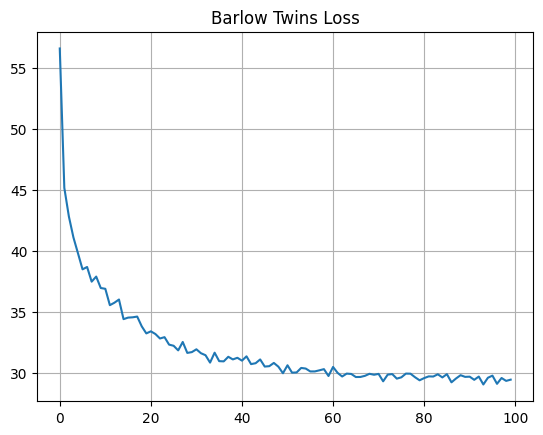

# Full model Training

In [ ]:
import tensorflow as tf

custom_objects = {
    "PatchPartition": PatchPartition,
    "LinearEmbedding": LinearEmbedding,
    "PatchMerging": PatchMerging,
    "WindowAttention": WindowAttention,
    "DropPath": DropPath,
    "SwinTransformerBlock": SwinTransformerBlock,
    "MLP": MLP
}

loaded_model = tf.keras.models.load_model("barlow_twins_swin_cellSeg_best.keras",custom_objects=custom_objects)

# Extract the Swin encoder submodel (that outputs skip1, skip2, skip3)
swin_encoder = loaded_model.layers[1]  # Index depends on model structure; adjust if needed

# Verify skip connections
print(swin_encoder.output)

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Embedding, GlobalAveragePooling1D, GlobalAvgPool2D,
    Layer, LayerNormalization, Softmax, Lambda, Add, SeparableConv2D,
    MaxPooling2D, BatchNormalization, Activation, Conv2D, UpSampling2D,
    concatenate, Rescaling, Reshape
)
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K

##############################################
# Swin Transformer Components
##############################################

@tf.keras.utils.register_keras_serializable()
class PatchPartition(Layer):
    def __init__(self, window_size=4, **kwargs):
        super(PatchPartition, self).__init__(**kwargs)
        self.window_size = window_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.window_size, self.window_size, 1],
            strides=[1, self.window_size, self.window_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

@tf.keras.utils.register_keras_serializable()
class LinearEmbedding(Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(LinearEmbedding, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = Dense(projection_dim)
        self.position_embedding = Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        patches_embed = self.projection(patch)
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        positions_embed = self.position_embedding(positions)
        encoded = patches_embed + positions_embed
        return encoded

@tf.keras.utils.register_keras_serializable()
class PatchMerging(Layer):
    def __init__(self, input_resolution, channels, **kwargs):
        super(PatchMerging, self).__init__(**kwargs)
        self.input_resolution = input_resolution
        self.channels = channels
        self.linear_trans = Dense(2 * channels, use_bias=False)

    def call(self, x):
        height, width = self.input_resolution
        x = tf.reshape(x, shape=(-1, height, width, self.channels))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * self.channels))
        x = self.linear_trans(x)
        return x

@tf.keras.utils.register_keras_serializable()
class MLP(Layer):
    def __init__(self, hidden_features, out_features, dropout_rate=0.1, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.dense1 = Dense(hidden_features, activation=tf.nn.gelu)
        self.dense2 = Dense(out_features)
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.dropout(x)
        return x

@tf.keras.utils.register_keras_serializable()
class WindowAttention(Layer):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None,
                 attn_drop=0., proj_drop=0., **kwargs):
        super(WindowAttention, self).__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size  # tuple (Wh, Ww)
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        initializer = TruncatedNormal(mean=0., stddev=.02)
        table_shape = ((2*self.window_size[0]-1) * (2*self.window_size[1]-1), num_heads)
        self.relative_position_bias_table = tf.Variable(
            initializer(shape=table_shape), trainable=True
        )
        # Compute relative position index.
        coords_h = tf.range(self.window_size[0])
        coords_w = tf.range(self.window_size[1])
        coords = tf.stack(tf.meshgrid(coords_h, coords_w, indexing='ij'))
        coords_flatten = tf.reshape(coords, [2, -1])
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = tf.transpose(relative_coords, perm=[1,2,0])
        relative_coords += [self.window_size[0]-1, self.window_size[1]-1]
        relative_coords = relative_coords * [2*self.window_size[1]-1, 1]
        self.relative_position_index = tf.reduce_sum(relative_coords, axis=-1)
        self.qkv = Dense(dim * 3, use_bias=qkv_bias, kernel_initializer=initializer)
        self.attn_drop = Dropout(attn_drop)
        self.proj = Dense(dim, kernel_initializer=initializer)
        self.proj_drop = Dropout(proj_drop)
        self.softmax = Softmax(axis=-1)

    def call(self, x, mask=None):
        B, N, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2]
        qkv = self.qkv(x)
        qkv = tf.reshape(qkv, [B, N, 3, self.num_heads, C // self.num_heads])
        qkv = tf.transpose(qkv, perm=[2, 0, 3, 1, 4])
        q, k, v = qkv[0], qkv[1], qkv[2]
        q = q * self.scale
        attn = tf.einsum('bhqd,bhkd->bhqk', q, k)
        relative_position_bias = tf.gather(
            self.relative_position_bias_table,
            tf.reshape(self.relative_position_index, [-1])
        )
        relative_position_bias = tf.reshape(
            relative_position_bias,
            [self.window_size[0]*self.window_size[1],
             self.window_size[0]*self.window_size[1], -1]
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=[2,0,1])
        attn = attn + relative_position_bias[None, ...]
        if mask is not None:
            nW = tf.shape(mask)[0]
            attn = tf.reshape(attn, [-1, nW, self.num_heads, N, N]) + mask[:, None, :, :]
            attn = tf.reshape(attn, [-1, self.num_heads, N, N])
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)
        attn = self.attn_drop(attn)
        x = tf.einsum('bhqk,bhkd->bhqd', attn, v)
        x = tf.transpose(x, perm=[0,2,1,3])
        x = tf.reshape(x, [B, N, C])
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

@tf.keras.utils.register_keras_serializable()
def window_partition(x, window_size):
    # x shape: (B, H, W, C)
    B, H, W, C = x.shape
    num_patch_y = H // window_size
    num_patch_x = W // window_size
    x = tf.reshape(x, [-1, num_patch_y, window_size, num_patch_x, window_size, C])
    x = tf.transpose(x, perm=[0,1,3,2,4,5])
    windows = tf.reshape(x, [-1, window_size, window_size, C])
    return windows

@tf.keras.utils.register_keras_serializable()
def window_reverse(windows, window_size, H, W):
    # windows shape: (num_windows*B, window_size, window_size, C)
    C = windows.shape[-1]
    B = tf.shape(windows)[0] // (H * W // window_size // window_size)
    x = tf.reshape(windows, [B, H // window_size, W // window_size, window_size, window_size, C])
    x = tf.transpose(x, perm=[0,1,3,2,4,5])
    x = tf.reshape(x, [B, H, W, C])
    return x

@tf.keras.utils.register_keras_serializable()
class DropPath(Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super(DropPath, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x, training=False):
        if (self.drop_prob == 0.) or (not training):
            return x
        keep_prob = 1 - self.drop_prob
        shape = (tf.shape(x)[0],) + (1,) * (len(x.shape) - 1)
        random_tensor = keep_prob + tf.random.uniform(shape, dtype=x.dtype)
        random_tensor = tf.floor(random_tensor)
        return (x / keep_prob) * random_tensor

@tf.keras.utils.register_keras_serializable()
class SwinTransformerBlock(Layer):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0., **kwargs):
        super(SwinTransformerBlock, self).__init__(**kwargs)
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        self.norm1 = LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(dim, window_size=(self.window_size, self.window_size),
                                      num_heads=num_heads, qkv_bias=qkv_bias,
                                      qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else lambda x, training=False: x
        self.norm2 = LayerNormalization(epsilon=1e-5)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(mlp_hidden_dim, dim, dropout_rate=drop)
        if self.shift_size > 0:
            H, W = self.input_resolution
            img_mask = np.zeros((1, H, W, 1))
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            img_mask = tf.constant(img_mask)
            mask_windows = window_partition(img_mask, self.window_size)
            mask_windows = tf.reshape(mask_windows, [-1, self.window_size * self.window_size])
            attn_mask = mask_windows[:, None, :] - mask_windows[:, :, None]
            self.attn_mask = tf.where(attn_mask==0, 0.0, -100.0)
        else:
            self.attn_mask = None

    def call(self, x, training=False):
        H, W = self.input_resolution
        B, L, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2]
        shortcut = x
        x = self.norm1(x)
        x = tf.reshape(x, (-1, H, W, C))
        if self.shift_size > 0:
            shifted_x = tf.roll(x, shift=[-self.shift_size, -self.shift_size], axis=[1,2])
        else:
            shifted_x = x
        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(x_windows, [-1, self.window_size * self.window_size, C])
        attn_windows = self.attn(x_windows, mask=self.attn_mask)
        attn_windows = tf.reshape(attn_windows, [-1, self.window_size, self.window_size, C])
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)
        if self.shift_size > 0:
            x = tf.roll(shifted_x, shift=[self.shift_size, self.shift_size], axis=[1,2])
        else:
            x = shifted_x
        x = tf.reshape(x, [-1, H*W, C])
        x = shortcut + self.drop_path(x, training=training)
        x = x + self.drop_path(self.mlp(self.norm2(x)), training=training)
        return x

##############################################
# Build Swin Encoder for Segmentation
##############################################

def build_swin_encoder(input_shape=(512,512,3), embed_dim=96, window_size=4, num_heads=8):
    inputs = Input(shape=input_shape)
    num_patch_x = input_shape[0] // window_size  # e.g., 512/4 = 128
    num_patch_y = input_shape[1] // window_size     # 128
    patches = PatchPartition(window_size)(inputs)
    x = LinearEmbedding(num_patch_x * num_patch_y, embed_dim)(patches)  # (B, 16384, 96)

    # Stage 1: Two Swin blocks.
    x = SwinTransformerBlock(dim=embed_dim,
                             input_resolution=(num_patch_x, num_patch_y),
                             num_heads=num_heads,
                             window_size=window_size,
                             shift_size=0)(x)
    x = SwinTransformerBlock(dim=embed_dim,
                             input_resolution=(num_patch_x, num_patch_y),
                             num_heads=num_heads,
                             window_size=window_size,
                             shift_size=1)(x)
    skip1 = x  # (B, 16384, 96)

    # Stage 2: Patch merging then two Swin blocks.
    x = PatchMerging((num_patch_x, num_patch_y), channels=embed_dim)(x)  # (B, 4096, 192)
    new_res = (num_patch_x // 2, num_patch_y // 2)  # (64,64)
    x = SwinTransformerBlock(dim=embed_dim*2,
                             input_resolution=new_res,
                             num_heads=num_heads,
                             window_size=window_size,
                             shift_size=0)(x)
    x = SwinTransformerBlock(dim=embed_dim*2,
                             input_resolution=new_res,
                             num_heads=num_heads,
                             window_size=window_size,
                             shift_size=1)(x)
    skip2 = x  # (B, 4096, 192)

    # Stage 3: Another patch merging then two Swin blocks.
    x = PatchMerging(new_res, channels=embed_dim*2)(x)  # (B, 1024, 384)
    new_res = (new_res[0] // 2, new_res[1] // 2)  # (32,32)
    x = SwinTransformerBlock(dim=embed_dim*4,
                             input_resolution=new_res,
                             num_heads=num_heads,
                             window_size=window_size,
                             shift_size=0)(x)
    x = SwinTransformerBlock(dim=embed_dim*4,
                             input_resolution=new_res,
                             num_heads=num_heads,
                             window_size=window_size,
                             shift_size=1)(x)
    skip3 = x  # (B, 1024, 384)

    # Reshape skip connections to 2D feature maps.
    skip1_reshaped = Reshape((num_patch_x, num_patch_y, embed_dim))(skip1)         # (B, 128, 128, 96)
    skip2_reshaped = Reshape((num_patch_x//2, num_patch_y//2, embed_dim*2))(skip2)   # (B, 64, 64, 192)
    skip3_reshaped = Reshape((num_patch_x//4, num_patch_y//4, embed_dim*4))(skip3)   # (B, 32, 32, 384)

    model = Model(inputs, [skip1_reshaped, skip2_reshaped, skip3_reshaped])
    return model

##############################################
# Segmentation Decoder (UNet-style)
##############################################

def double_conv_layer(x, filter_size, size, dropout, batch_norm=False):
    axis = 3
    conv = SeparableConv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = SeparableConv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = Dropout(dropout)(conv)
    shortcut = Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm:
        shortcut = BatchNormalization(axis=axis)(shortcut)
    res_path = Add()([shortcut, conv])
    return res_path

def full_decoder(deep_feature, skip_connections):
    # skip_connections: [skip1, skip2]
    # deep_feature: (B, 32, 32, 384)
    x = UpSampling2D(size=(2, 2))(deep_feature)        # (B, 64, 64, 384)
    x = concatenate([x, skip_connections[1]])           # fuse with skip2 (B, 64, 64, 384+192)
    x = double_conv_layer(x, filter_size=3, size=192, dropout=0.1, batch_norm=True)

    x = UpSampling2D(size=(2, 2))(x)                      # (B, 128, 128, ?)
    x = concatenate([x, skip_connections[0]])           # fuse with skip1 (B, 128, 128, ?)
    x = double_conv_layer(x, filter_size=3, size=128, dropout=0.1, batch_norm=True)

    x = UpSampling2D(size=(2, 2))(x)                      # (B, 256, 256, ?)
    x = double_conv_layer(x, filter_size=3, size=64, dropout=0.1, batch_norm=True)

    x = UpSampling2D(size=(2, 2))(x)                      # (B, 512, 512, ?)
    x = double_conv_layer(x, filter_size=3, size=32, dropout=0.1, batch_norm=True)
    return x

def output_layer(inputs):
    x = Conv2D(1, kernel_size=(1,1))(inputs)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    return x

##############################################
# Build and Train Segmentation Model
##############################################

import tensorflow as tf
import tensorflow.keras.backend as K


def dice_coeff(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)

    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f)

    return (2. * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    return 0.5 * bce + 0.5 * dice_loss(y_true, y_pred)

# Your model building code with the Swin encoder remains the same:
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 3
BATCH_SIZE = 8
EPOCHS = 100

# Build the Swin encoder.
swin_encoder = build_swin_encoder(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    embed_dim=96,
    window_size=4,
    num_heads=8
)

# Load pretrained weights from Barlow Twins training.
swin_encoder.load_weights("barlow_twins_swin_cellSeg_best.keras", skip_mismatch=True)

# Extract skip connections.
skip1, skip2, skip3 = swin_encoder.outputs

# Build the decoder using the deepest feature (skip3) and the skip connections.
x = full_decoder(skip3, [skip1, skip2])
outputs = output_layer(x)
segmentation_model = Model(swin_encoder.input, outputs)

segmentation_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=bce_dice_loss,
    metrics=[
        "accuracy",
        dice_coeff,
        tf.keras.metrics.Precision(),
        tf.keras.metrics.MeanIoU(num_classes=2),
        tf.keras.metrics.Recall()
    ]
)

#segmentation_model.summary()


In [ ]:
# Loading trained data
from tensorflow.keras.models import load_model
# Load the model and pass the custom_objects dictionary.
segmentation_model = load_model("segmentation_model.keras",
                                custom_objects={
                                    "bce_dice_loss": bce_dice_loss,
                                    "dice_coeff": dice_coeff
                                })

# Now you can use the model for evaluation, prediction, or further training.
#segmentation_model.summary()

# Plotting architecture

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Assuming segmentation_model is your built model:
plot_model(segmentation_model, to_file='segmentation_model.png', show_shapes=True, show_layer_names=True)

# Display the image in the notebook
Image('segmentation_model.png')

In [ ]:
from graphviz import Digraph

dot = Digraph(comment='Swin Transformer Segmentation Model')

# Add nodes (example nodes; you'll need to expand based on your architecture)
dot.node('A', 'Input\n(512x512x3)')
dot.node('B', 'Patch Partition\n(Output: (B, 16384, 48))')
dot.node('C', 'Linear Embedding\n(Output: (B, 16384, 96))')
dot.node('D', 'Swin Block Stage 1\n(Output: (B, 16384, 96))')
dot.node('E', 'Patch Merging\n(Output: (B, 4096, 192))')
dot.node('F', 'Swin Block Stage 2\n(Output: (B, 4096, 192))')
dot.node('G', 'Decoder\n(Various Upsampling + Conv layers)')
dot.node('H', 'Output Layer\n(Output: (B, 512, 512, 1))')

# Add edges
dot.edges(['AB', 'BC', 'CD', 'DE', 'EF', 'FG', 'GH'])

# Render and display the diagram (view=True opens in a new window if possible)
dot.render('model_diagram', format='png', view=True)


'model_diagram.png'

In [ ]:
print(len(X_val), len(Y_val))

200 200


In [ ]:
print(X_val.shape, Y_val.shape)


(200, 512, 512, 3) (200, 512, 512, 1)


# Fine tuning of Swin encoder and decoder

In [ ]:

# Train segmentation model.
history = segmentation_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=BATCH_SIZE,
    epochs=100
)

from tensorflow.keras.callbacks import ModelCheckpoint

# Paths to save models
BEST_SEG_MODEL = "segmentation_model_cellSeg_best.keras"
LAST_SEG_MODEL = "segmentation_model_cellSeg_last.keras"

# Callbacks
checkpoint_best = ModelCheckpoint(
    filepath=BEST_SEG_MODEL,
    monitor='val_dice_coeff',       # Monitor Dice Coefficient on validation set
    mode='max',                     # Because higher dice is better
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

checkpoint_last = ModelCheckpoint(
    filepath=LAST_SEG_MODEL,
    save_best_only=False,
    save_weights_only=False,
    verbose=1
)

# Train segmentation model with callbacks
history = segmentation_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=BATCH_SIZE,
    epochs=100,
    callbacks=[checkpoint_best, checkpoint_last]
)

# Load best model if needed
# segmentation_model = tf.keras.models.load_model(BEST_SEG_MODEL)

# Evaluate on test set
test_loss, test_acc, test_dice, test_mean_iou, test_precision, test_recall = segmentation_model.evaluate(X_test, Y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)
print("Test Dice Coefficient:", test_dice)
print("Test Mean IoU:", test_mean_iou)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)




In [ ]:
segmentation_model.save("segmentation_model.keras")

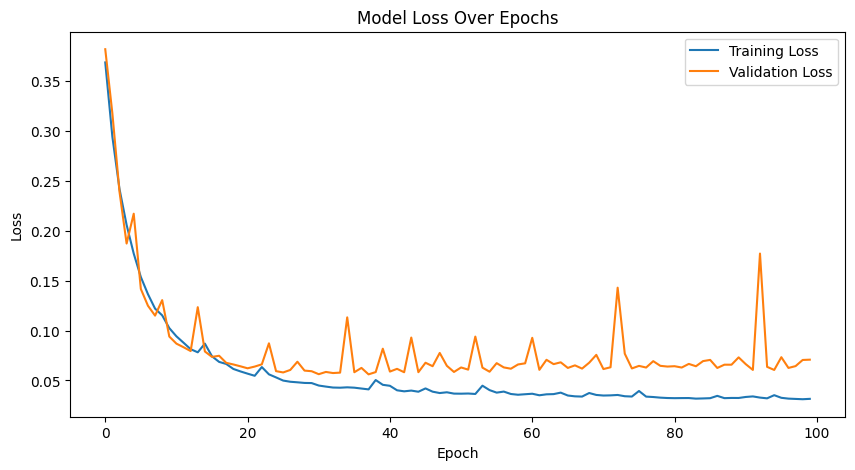

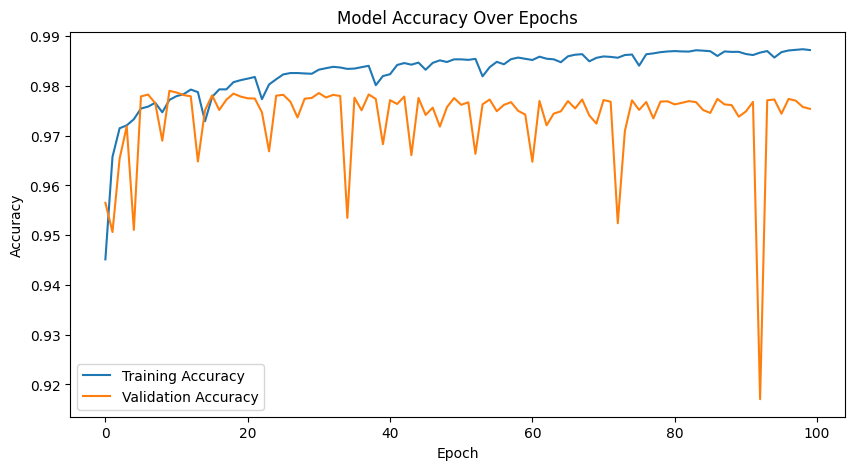

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# If you have accuracy metrics, you can plot them too:
if 'accuracy' in history.history:
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the test set.
# This returns a probability map for each pixel.
predictions = segmentation_model.predict(X_test)

# Optionally, you may threshold the predictions to obtain binary masks.
threshold = 0.5
binary_predictions = (predictions > threshold).astype(np.uint8)

# Visualize a few samples.
num_samples = 40
for i in range(num_samples):
    plt.figure(figsize=(15, 5))

    # Display the input image.
    plt.subplot(1, 3, 1)
    plt.imshow((X_test[i]*255).astype('uint8'))
    plt.title("Input Image")
    plt.axis("off")

    # Display the ground truth mask.
    plt.subplot(1, 3, 2)
    plt.imshow(Y_test[i].squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    # Display the predicted mask (binary).
    plt.subplot(1, 3, 3)
    plt.imshow(binary_predictions[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()


In [ ]:
def compute_iou(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 1.0

def compute_dice(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    intersection = np.logical_and(y_true, y_pred).sum()
    total = y_true.sum() + y_pred.sum()
    return (2.0 * intersection) / total if total != 0 else 1.0

def compute_precision(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    TP = np.logical_and(y_true, y_pred).sum()
    FP = np.logical_and(np.logical_not(y_true), y_pred).sum()
    # If there are no positive predictions, define precision as 1.0 (or 0.0) as per your convention.
    return TP / (TP + FP) if (TP + FP) > 0 else 1.0

def compute_recall(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    TP = np.logical_and(y_true, y_pred).sum()
    FN = np.logical_and(y_true, np.logical_not(y_pred)).sum()
    return TP / (TP + FN) if (TP + FN) > 0 else 1.0

# Assume predictions have been generated and thresholded as follows:
predictions = segmentation_model.predict(X_test)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(np.uint8)

# Calculate and print the metrics for each sample.
for i in range(len(Y_test)):
    gt_mask = Y_test[i].squeeze()
    pred_mask = binary_predictions[i].squeeze()

    iou_val = compute_iou(gt_mask, pred_mask)
    dice_val = compute_dice(gt_mask, pred_mask)
    precision_val = compute_precision(gt_mask, pred_mask)
    recall_val = compute_recall(gt_mask, pred_mask)

    print(f"Sample {i}: IoU = {iou_val:.4f}, Dice = {dice_val:.4f}, Precision = {precision_val:.4f}, Recall = {recall_val:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
Sample 0: IoU = 0.9500, Dice = 0.9744, Precision = 0.9773, Recall = 0.9715
Sample 1: IoU = 0.9419, Dice = 0.9701, Precision = 0.9747, Recall = 0.9655
Sample 2: IoU = 0.8372, Dice = 0.9114, Precision = 0.9732, Recall = 0.8569
Sample 3: IoU = 0.9619, Dice = 0.9806, Precision = 0.9865, Recall = 0.9747
Sample 4: IoU = 0.9174, Dice = 0.9569, Precision = 0.9564, Recall = 0.9575
Sample 5: IoU = 0.8816, Dice = 0.9371, Precision = 0.9829, Recall = 0.8954
Sample 6: IoU = 0.9155, Dice = 0.9559, Precision = 0.9954, Recall = 0.9194
Sample 7: IoU = 0.8617, Dice = 0.9257, Precision = 0.9531, Recall = 0.8998
Sample 8: IoU = 0.8866, Dice = 0.9399, Precision = 0.9869, Recall = 0.8971
Sample 9: IoU = 0.8883, Dice = 0.9409, Precision = 0.9176, Recall = 0.9653
Sample 10: IoU = 0.9126, Dice = 0.9543, Precision = 0.9699, Recall = 0.9391
Sample 11: IoU = 0.8795, Dice = 0.9359, Precision = 0.9812, Recall = 0.8946
Sample 12: IoU = 0.9545, Dice = 0.9767, Precision = 0.9981,

In [ ]:
def compute_iou(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 1.0

def compute_dice(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    intersection = np.logical_and(y_true, y_pred).sum()
    total = y_true.sum() + y_pred.sum()
    return (2.0 * intersection) / total if total != 0 else 1.0

def compute_precision(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    TP = np.logical_and(y_true, y_pred).sum()
    FP = np.logical_and(np.logical_not(y_true), y_pred).sum()
    # If there are no positive predictions, define precision as 1.0 (or 0.0) as per your convention.
    return TP / (TP + FP) if (TP + FP) > 0 else 1.0

def compute_recall(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    TP = np.logical_and(y_true, y_pred).sum()
    FN = np.logical_and(y_true, np.logical_not(y_pred)).sum()
    return TP / (TP + FN) if (TP + FN) > 0 else 1.0

# Assume predictions have been generated and thresholded as follows:
predictions = segmentation_model.predict(X_val)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(np.uint8)

# Calculate and print the metrics for each sample.
for i in range(len(Y_val)):
    gt_mask = Y_val[i].squeeze()
    pred_mask = binary_predictions[i].squeeze()

    iou_val = compute_iou(gt_mask, pred_mask)
    dice_val = compute_dice(gt_mask, pred_mask)
    precision_val = compute_precision(gt_mask, pred_mask)
    recall_val = compute_recall(gt_mask, pred_mask)

    print(f"Sample {i}: IoU = {iou_val:.4f}, Dice = {dice_val:.4f}, Precision = {precision_val:.4f}, Recall = {recall_val:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
Sample 0: IoU = 0.9457, Dice = 0.9721, Precision = 0.9876, Recall = 0.9571
Sample 1: IoU = 0.8954, Dice = 0.9448, Precision = 0.9868, Recall = 0.9063
Sample 2: IoU = 0.9195, Dice = 0.9581, Precision = 0.9622, Recall = 0.9540
Sample 3: IoU = 0.8833, Dice = 0.9380, Precision = 0.9973, Recall = 0.8854
Sample 4: IoU = 0.8731, Dice = 0.9322, Precision = 0.9926, Recall = 0.8788
Sample 5: IoU = 0.9224, Dice = 0.9596, Precision = 0.9621, Recall = 0.9571
Sample 6: IoU = 0.9281, Dice = 0.9627, Precision = 0.9910, Recall = 0.9360
Sample 7: IoU = 0.8899, Dice = 0.9418, Precision = 0.9628, Recall = 0.9216
Sample 8: IoU = 0.9275, Dice = 0.9624, Precision = 0.9967, Recall = 0.9304
Sample 9: IoU = 0.9092, Dice = 0.9524, Precision = 0.9985, Recall = 0.9104
Sample 10: IoU = 0.9470, Dice = 0.9728, Precision = 0.9753, Recall = 0.9703
Sample 11: IoU = 0.8756, Dice = 0.9337, Precision = 0.9741, Recall = 0.8965
Sample 12: IoU = 0.9042, Dice = 0.9497, Precision = 0.9886,

# Evaluation on Test Results

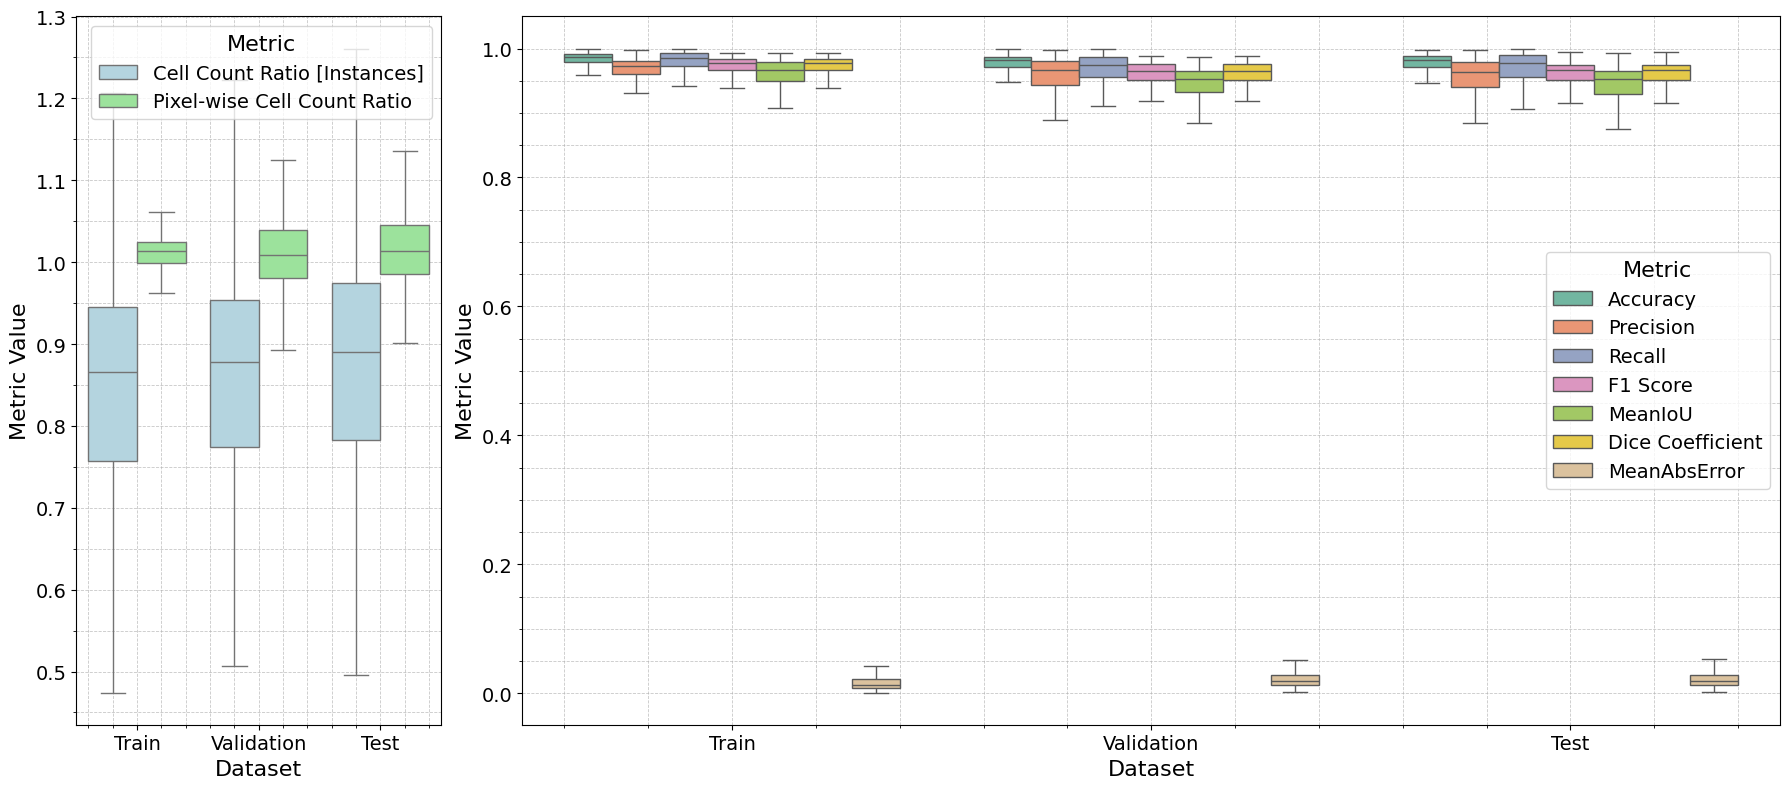